# CLT Project - Stage III





- **Author:**             Arian Contessotto, Tim Giger, Levin Reichmuth
- **Submission Date:**    1 June 2023

## 1. Setup & Data Loading

If running on Colab, install the required packages and load data.

In [ ]:
# Clone repo with dataset
!git clone https://github.com/syX113/hslu-nlp

In [ ]:
# Check if files are loaded
!ls hslu-nlp/stage2/annotated/

In [ ]:
# Required package installation
!transformers==4.28.0
!pip install torch

### 1.1 Import Packages & Downloads

In [1]:
# Imports
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import XLNetTokenizerFast, XLNetForSequenceClassification
from transformers import EarlyStoppingCallback
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

2023-05-28 13:38:37.295971: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-28 13:38:37.321868: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 13:38:37.724534: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The final dataframe from stage one is loaded. These data are the basis for stage two.

In [18]:
# Define file name
esg_file = '../stage2/output/stage2_output.csv' # Local filepath
#esg_file = 'hslu-nlp/stage2/output/stage2_output.csv' # Filepath on Colab

# Define function to load and merge data
def load_data(file):

    # Load the data
    df = pd.read_csv(file, delimiter = '|')

    # Apply eval function
    df['esg_topics'] = df['esg_topics'].apply(eval)
    df['sentence_tokens'] = df['sentence_tokens'].apply(eval)
    df['st2_sentiment_llm_continuous'] = df['st2_sentiment_llm_continuous'].apply(eval)
    df['st2_sentiment_llm_categorical'] = df['st2_sentiment_llm_categorical'].apply(eval)

    return df

df = load_data(esg_file)

# Print shape and diyplay header
print(df.shape)
df.head()

(11072, 20)


,company,datatype,title,date,domain,cnt_word,cleaned_content,esg_topics,internal,symbol,sentence_tokens,market_cap_in_usd_b,sector,industry,year_month,year,month,st1_sentiment_continuous,st2_sentiment_llm_continuous,st2_sentiment_llm_categorical
0,Beiersdorf,sustainability_report,BeiersdorfAG Sustainability Report 2021,2021-03-31,NaN,4877,brand strategy sustainability agenda care beyo...,"[CleanWater, GHGEmission, ProductLiability, Va...",1,BEI,[brands strategy sustainability agenda care be...,25.99,Consumer Staples,Household & Personal Products,2021-03,2021,3,0.398557,"[0.4510159492492676, 0.6138717532157898, 0.226...","[0.5, 0.5, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 1.0, ..."
1,Deutsche Telekom,sustainability_report,DeutscheTelekomAG Sustainability Report 2021,2021-03-31,NaN,53913,management fact deutsche telekoms cr report th...,"[DataSecurity, Iso50001, GlobalWarming, Produc...",1,DTE,"[management facts, deutsche telekom cr report,...",101.78,Communication Services,Telecom Services,2021-03,2021,3,0.205642,"[0.3575633764266968, 0.29088786244392395, 0.50...","[0.5, 0.0, 0.5, 0.0, 0.5, 0.5, 0.5, 0.5, 1.0, ..."
2,Vonovia,sustainability_report,VonoviaSE Sustainability Report 2021,2021-03-31,NaN,36707,sustainable future se sustainability report de...,"[Whistleblowing, DataSecurity, Vaccine, GHGEmi...",1,VNA,"[sustainable future, se sustainability report ...",20.35,Real Estate,Real Estate Services,2021-03,2021,3,0.242471,"[0.45703375339508057, 0.38698673248291016, 0.2...","[0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.0, 0.5, 0.0, ..."
3,Merck,sustainability_report,MerckKGaA Sustainability Report 2021,2021-03-31,NaN,46497,management employee profile attractive employe...,"[DataSecurity, DataMisuse, DrugResistance, Iso...",1,MRK,[management employees profile attractive emplo...,87.64,Healthcare,Drug Manufacturers—Specialty & Generic,2021-03,2021,3,0.235490,"[0.3637859523296356, 0.6118264198303223, 0.489...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."
4,MTU,sustainability_report,MTUAeroEngines Sustainability Report 2020,2020-03-31,NaN,21571,sustainability go far beyond climate action sa...,"[WorkLifeBalance, Corruption, AirQuality, Data...",1,MTX,[sustainability goes far beyond climate action...,12.24,Industrials,Aerospace & Defense,2020-03,2020,3,0.241814,"[0.4608282744884491, 0.4620864689350128, 0.430...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.5, 0.5, ..."


In [19]:
# Flatten the continuous sentiments to analyze distribution and adjust class discretization to 0.0, 0.5 and 1.0
flattened_sentiments_cont = np.hstack(df['st2_sentiment_llm_continuous'].values)
flattened_sentiments_cat= np.hstack(df['st2_sentiment_llm_categorical'].values)

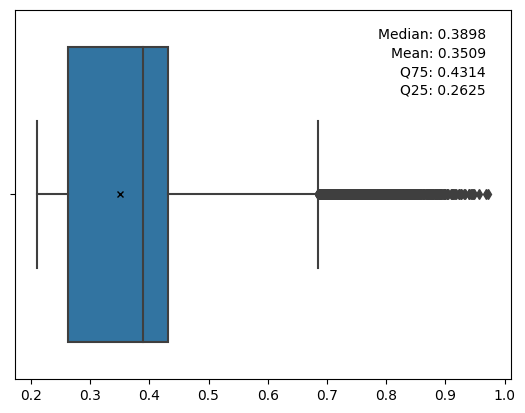

In [20]:
# Create boxplot
ax = sns.boxplot(x=flattened_sentiments_cont, showmeans=True,meanprops={"marker":"x","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5"})

# Calculate statistics
median = np.median(flattened_sentiments_cont)
mean = np.mean(flattened_sentiments_cont)
q75, q25 = np.percentile(flattened_sentiments_cont, [75 ,25])
iqr = q75 - q25

# Add text with statistics
plt.text(0.95, 0.95, f"Median: {median:.4f}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
plt.text(0.95, 0.90, f"Mean: {mean:.4f}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
plt.text(0.95, 0.85, f"Q75: {q75:.4f}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
plt.text(0.95, 0.80, f"Q25: {q25:.4f}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
plt.show()


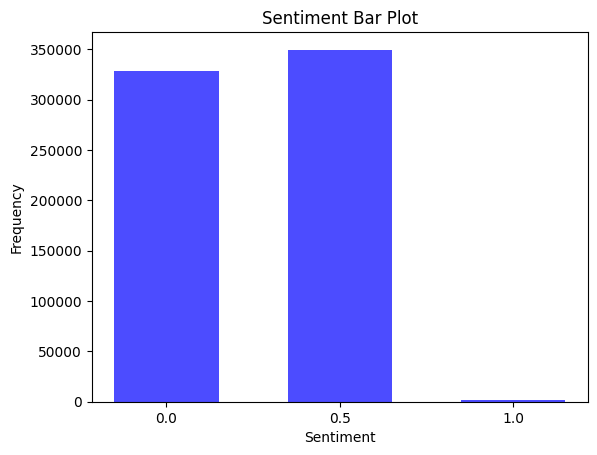

In [21]:
# Count the occurrences of each value
value_counts = pd.Series(flattened_sentiments_cat).value_counts()
# Create a bar plot with smaller bars
plt.bar(value_counts.index, value_counts.values, color='blue', alpha=0.7, width=0.3)
plt.title('Sentiment Bar Plot')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks([0.0, 0.5, 1.0])
plt.show()

In [22]:
# Function to adjust the sentiment discretization
def discretize_sentiment(value):
    if value <= 0.35: # Mean of st2_sentiment_llm_continuous
        return 0.0
    elif value <= 0.43145: # Q75 of st2_sentiment_llm_continuous + a small shift
        return 0.5
    else:
        return 1.0
    
def discretize_sentiments(sentiments):
    if sentiments is np.nan:
        return np.nan
    return [discretize_sentiment(sentiment) for sentiment in sentiments]

In [23]:
df['st2_sentiment_llm_categorical'] = df['st2_sentiment_llm_continuous'].apply(discretize_sentiments)

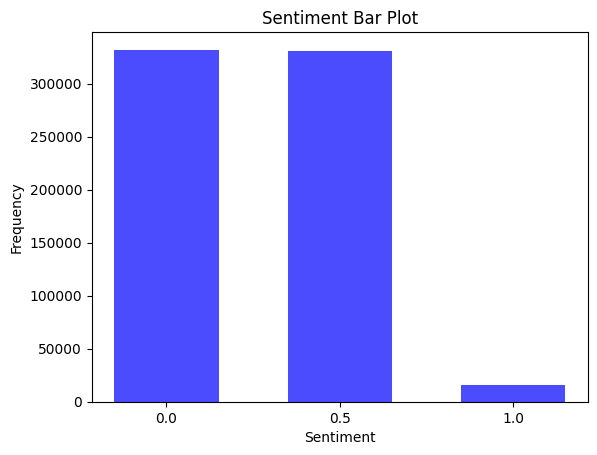

In [24]:
flattened_sentiments_cat= np.hstack(df['st2_sentiment_llm_categorical'].values)

# Count the occurrences of each value
value_counts = pd.Series(flattened_sentiments_cat).value_counts()
# Create a bar plot with smaller bars
plt.bar(value_counts.index, value_counts.values, color='blue', alpha=0.7, width=0.3)
plt.title('Sentiment Bar Plot')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks([0.0, 0.5, 1.0])
plt.show()

### 1.3 Create different Dataframes (Sentences & full Document)

In [25]:
def create_sentence_df(data):

    # Select relevant columns
    data = data[['internal','sentence_tokens','st2_sentiment_llm_categorical']]

    # Explode the tokens, so each sentence is a row
    data = data.set_index(['internal']).apply(pd.Series.explode).reset_index()

    # Rename the columns and change order
    data.rename(columns={'sentence_tokens': 'sentence', 'st2_sentiment_llm_categorical': 'sentiment'}, inplace=True)
    data = data[['internal', 'sentence', 'sentiment']]

    # Convert types
    data['internal'] = data['internal'].astype(int)
    data['sentence'] = data['sentence'].astype(str)
    data['sentiment'] = data['sentiment'].astype(float)
    
    return data

# Create sentence data
sentence_df = create_sentence_df(df)

# Display header and shape
print(sentence_df.shape)
sentence_df.head()

(678930, 3)


,internal,sentence,sentiment
0,1,brands strategy sustainability agenda care bey...,1.0
1,1,successfully reduced carbon footprint absolute...,1.0
2,1,end consumer business returned levels reduced ...,0.0
3,1,decoupling human economic activity natural res...,0.0
4,1,inspired beiersdorf ambitious sustainability a...,1.0


In [26]:
# Function to create document data
def create_document_df(data):

    # Join tokens
    data['document'] = data['sentence_tokens'].apply(' '.join)  # Convert tokens to strings
    data['sentiment'] = data['st2_sentiment_llm_categorical'].apply(np.mean).apply(discretize_sentiment)

    # Convert types
    data['internal'] = data['internal'].astype(int)
    data['sentence'] = data['document'].astype(str)
    data['sentiment'] = data['sentiment'].astype(float)

    # Return needed columns and discretized mean of the sentiment
    return data[['internal', 'document', 'sentiment']]

# Create sentence data
document_df = create_document_df(df)

# Display header and shape
print(document_df.shape)
document_df.head()

(11072, 3)


,internal,document,sentiment
0,1,brands strategy sustainability agenda care bey...,1.0
1,1,management facts deutsche telekom cr report th...,1.0
2,1,sustainable future se sustainability report de...,1.0
3,1,management employees profile attractive employ...,1.0
4,1,sustainability goes far beyond climate action ...,1.0


The subsets for the training should have equally distributed classes. In addition, external and internal documents should be represented.  
One of these conditions needs to be more "loose", we decide class equality is more important.

In [27]:
sentence_df['sentiment'].value_counts().min()

16075

In [28]:
def balance_sentiment_and_internal_sentences(df):
    # Get minimum number of observations across sentiment classes
    min_internal_count = df['sentiment'].value_counts().min()
    
    # Get the minimum number of observations between internal == 0 and internal == 1
    min_sentiment_count = min(df[df['internal'] == 0].shape[0], df[df['internal'] == 1].shape[0], min_internal_count)

    # Create "balanced" dataframe
    balanced_df = pd.concat([df[df['internal'] == i].sample(min_sentiment_count*3, random_state=1) for i in df['internal'].unique()])

    return balanced_df

# Sample the sentence dataframe
sub_sentence_df = balance_sentiment_and_internal_sentences(sentence_df)

# Display header and shape
print(sub_sentence_df.shape)
sub_sentence_df.head()

(96450, 3)


,internal,sentence,sentiment
133546,1,flow acquisitions dividends uses cash flow acq...,0.5
228287,1,tour gave impression life physical disability ...,0.0
50137,1,internal principles guidelines reported water ...,0.0
80103,1,annual report management report structure busi...,0.0
49248,1,business segment currently reviewing whether i...,0.5


In [29]:
# Sample the document dataframe
sub_document_df = balance_sentiment_and_internal_sentences(document_df)

# Display header and shape
print(sub_document_df.shape)
sub_document_df.head()

(18, 3)


,internal,document,sentiment
58,1,ceo portrait corporate creating value global g...,0.0
88,1,balance sheet date events combined nonfinancia...,0.0
43,1,secure future expresses reason guides decision...,0.0
55,1,foreword content decarbonizing business respon...,0.0
73,1,combined management report sucheta group glanc...,0.0


In [30]:
# Inspect sampling results
print('Sentence subset:')
print(sub_sentence_df['internal'].value_counts())
print(sub_sentence_df['sentiment'].value_counts())
print('\n')
print('Document subset:')
print(sub_document_df['internal'].value_counts())
print(sub_document_df['sentiment'].value_counts())

Sentence subset:
1    48225
0    48225
Name: internal, dtype: int64
0.0    46601
0.5    46543
1.0     3306
Name: sentiment, dtype: int64


Document subset:
1    9
0    9
Name: internal, dtype: int64
0.0    18
Name: sentiment, dtype: int64


In [31]:
# Drop uncessary column and reset index
document_df = document_df.drop(columns=['internal']).reset_index(drop=True)
sentence_df = sentence_df.drop(columns=['internal']).reset_index(drop=True)
sub_sentence_df = sub_sentence_df.drop(columns=['internal']).reset_index(drop=True)

As a result, the models can be evaluated and trained with 2 approaches:  
- A dataframe containing the full document and a discretized mean sentiment of all included sentences
- A dataframe containing each sentence with the corresponding discretized sentiment  
- Two sampled subset dataframes for moel evaluation

"Discretized" corresponds to the labels 0.0 (negative), 0.5 (neutral) and 1.0 (positive).

## 2. Model Finetuning

The evaluation for the model is based on the following conceptual approach:
1. Select multiple pretrained (Huggingface) models, based on previous stages
2. Train the selected models on a small subset of the full documents and the single sentences to keep the training time short
3. Compare the training outcomes of the different models on the two subsets and select the best model

In [32]:
# Function to compute the comparison metrics
def compute_metrics(p):
    pred, labels = p
    
    # Use the appropriate metrics, since we don't have discrete classes but a continous score 
    mse = mean_squared_error(y_true=labels, y_pred=pred)
    mae = mean_absolute_error(y_true=labels, y_pred=pred)
    r2 = r2_score(y_true=labels, y_pred=pred)

    return {"MSE": mse, "MAE": mae, "R2": r2}

In [33]:
# Load Tensorboard for training monitoring
%load_ext tensorboard

In [34]:
# Kill potential Tensorboard process, so it don't block the port
!pkill -f "tensorboard"

In [36]:
# Start Tensorboard to monitor training processes
%tensorboard --logdir ./evaluation/ --port 6010

### 1.1 Finetune Model 1: *distilbert-base-uncased*

As a first test, we use the lightweight "distilbert-base-uncased" model and fine-tune it on the full documents and the sentences, since the finetuned *"nlptown/bert-base-multilingual-uncased-sentiment"* demonstrated high alignment with the gold standard in stage 2.  
Since BERT only accepts 512 input word tokens, the full documents are heavyily truncated.  

🤗 page: https://huggingface.co/distilbert-base-uncased

In [37]:
# Define pretrained tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=1) # 1 label to get a continuous score between 0 and 1

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.transformer.layer.4.attention.k_lin.bias', 'distilbert.transformer.layer.5.attention.v_lin.weight', 'distilbert.transformer.layer.4.attention.k_lin.weight', 'distilbert.transformer.layer.5.attention.k_lin.bias', 'distilbert.transformer.layer.4.attention.out_lin.bias', 'distilbert.transformer.layer.3.output_layer_norm.weight', 'distilbert.transformer.layer.2.output_layer_norm.weight', 'distilbert.transformer.l

In [38]:
# Create the torch datasets to use data in PyTorch and override necessary methods
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

#### Finetune *distilbert-base-uncased* on sentence subset

In [39]:
# Split the data with a 70%, 15% and 15% ratio (train, valid, test)
X = list(sub_sentence_df["sentence"])
y = list(sub_sentence_df["sentiment"])
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3) # Split 70% train data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5) # Split the other 30% in 50% each to get the correct ratio

# Tokenize the datasets
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create the train, validation and test dataset as PyTorch datasets
train_dataset_distilbert_sent = Dataset(X_train_tokenized, y_train)
val_dataset_distilbert_sent = Dataset(X_val_tokenized, y_val)
test_dataset_distilbert_sent = Dataset(X_test_tokenized, y_test)

In [40]:
# Define training arguments
args = TrainingArguments(
    output_dir="./evaluation/distilbert_sentences",
    evaluation_strategy="steps",
    eval_steps=1000,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    gradient_accumulation_steps=4,
    seed=0,
    optim="adamw_torch", # Use newer PyTorch optimizer
    learning_rate=2e-5,
    logging_steps=10,
    fp16=True,
    report_to='tensorboard')

# Define Huggingface Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset_distilbert_sent,
    eval_dataset=val_dataset_distilbert_sent,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [41]:
# Delete GPU cache
torch.cuda.empty_cache()
# Train pre-trained model
trainer.train()
# Save the model
model.save_pretrained("./models/distilbert_sentences")

Step,Training Loss,Validation Loss


#### Finetune *distilbert-base-uncased* on document subset

In [ ]:
# Split the data with a 70%, 15% and 15% ratio (train, valid, test)
X = list(sub_document_df["document"])
y = list(sub_document_df["sentiment"])
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3) # Split 70% train data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5) # Split the other 30% in 50% each to get the correct ratio

# Tokenize the datasets
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create the train, validation and test dataset as PyTorch datasets
train_dataset_distilbert_doc = Dataset(X_train_tokenized, y_train)
val_dataset_distilbert_doc = Dataset(X_val_tokenized, y_val)
test_dataset_distilbert_doc = Dataset(X_test_tokenized, y_test)

In [ ]:
# Define training arguments
args_distilbert = TrainingArguments(
    output_dir="./evaluation/distilbert_documents",
    evaluation_strategy="steps",
    eval_steps=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=100,
    gradient_accumulation_steps=4,
    seed=0,
    optim="adamw_torch", # Use newer PyTorch optimizer
    learning_rate=2e-5,
    logging_steps=1,
    fp16=True,
    report_to='tensorboard')

# Define Huggingface Trainer
trainer = Trainer(
    model=model,
    args=args_distilbert,
    train_dataset=train_dataset_distilbert_doc,
    eval_dataset=val_dataset_distilbert_doc,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
# Delete GPU cache
torch.cuda.empty_cache()
# Train pre-trained model
trainer.train()
# Save the model
model.save_pretrained("./models/distilbert_documents")

### 1.2 Finetune Model 2: *roberta-base*

As a second model for the comparison, we choose RoBERTa. It is a further development of BERT and should perform better.  

This model benefits substantially from extended training duration, larger data batches, and an increase in dataset size. Its performance further increases by eliminating the next sentence prediction objective and integrating longer sequences during training.  
Lastly, the model's optimization is boosted by dynamically altering the masking pattern applied to the training data.

Reference: https://arxiv.org/pdf/1907.11692.pdf  
🤗 page: https://huggingface.co/roberta-base

In [42]:
# Load default methods again, since a few are overwritten for destillbert
from datasets import Dataset 

In [43]:
# Load the tokenizer for RoBERTa
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

def tokenize_and_format_sentence(examples):

    # Tokenize the text and map sentiment to label
    tokenized_inputs = tokenizer(examples['sentence'], truncation=True, padding='max_length')
    labels = examples['sentiment']
    
    # Return both the tokenized inputs and labels
    return {**tokenized_inputs, 'labels': labels}

def tokenize_and_format_document(examples):
    # Same as above for documents
    tokenized_inputs = tokenizer(examples['document'], truncation=True, padding='max_length')
    labels = examples['sentiment']
    
    return {**tokenized_inputs, 'labels': labels}

In [44]:
# Load the base RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

#### Finetune *roberta-base* on sentence subset

In [45]:
# Train, validation and test split (70%, 15% and 15%)
train_dataset, temp_df = train_test_split(sub_sentence_df, test_size=0.3, random_state=42)
val_dataset, test_dataset = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)
test_dataset = Dataset.from_pandas(test_dataset)

# Tokenizing the datasets
train_dataset_roberta_sent = train_dataset.map(tokenize_and_format_sentence, batched=True)
val_dataset_roberta_sent = val_dataset.map(tokenize_and_format_sentence, batched=True)
test_dataset_roberta_sent = test_dataset.map(tokenize_and_format_sentence, batched=True)

# Set the correct data format for PyTorch
train_dataset_roberta_sent.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset_roberta_sent.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset_roberta_sent.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/67515 [00:00<?, ? examples/s]

Map:   0%|          | 0/14467 [00:00<?, ? examples/s]

Map:   0%|          | 0/14468 [00:00<?, ? examples/s]

In [46]:
# Prepare to train the model
args = TrainingArguments(
    output_dir="./evaluation/roberta_sentences",
    evaluation_strategy="steps",
    eval_steps=1000,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    gradient_accumulation_steps=4,
    seed=0,
    optim="adamw_torch", # Use newer PyTorch optimizer
    learning_rate=2e-5,
    logging_steps=10,
    fp16=True,
    report_to='tensorboard')

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset_roberta_sent,
    eval_dataset=val_dataset_roberta_sent
)

In [47]:
# Delete GPU cache
torch.cuda.empty_cache()
# Train the model
trainer.train()
# Save the model
model.save_pretrained("./models/roberta_sentences")

Step,Training Loss,Validation Loss


#### Finetune *roberta-base* on document subset

In [ ]:
# Train, validation and test split (70%, 15% and 15%)
train_dataset, temp_df = train_test_split(sub_document_df, test_size=0.3, random_state=42)
val_dataset, test_dataset = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)
test_dataset = Dataset.from_pandas(test_dataset)

# Tokenizing the datasets
train_dataset_roberta_doc = train_dataset.map(tokenize_and_format_document, batched=True)
val_dataset_roberta_doc = val_dataset.map(tokenize_and_format_document, batched=True)
test_dataset_roberta_doc = test_dataset.map(tokenize_and_format_document, batched=True)

# Set the correct data format for PyTorch
train_dataset_roberta_doc.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset_roberta_doc.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset_roberta_doc.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [ ]:
# Prepare to train the model
args = TrainingArguments(
    output_dir="./evaluation/roberta_documents",
    evaluation_strategy="steps",
    eval_steps=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=100,
    gradient_accumulation_steps=4,
    seed=0,
    optim="adamw_torch", # Use newer PyTorch optimizer
    learning_rate=2e-5,
    logging_steps=1,
    fp16=True,
    report_to='tensorboard')

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset_roberta_doc,
    eval_dataset=val_dataset_roberta_doc
)

In [ ]:
# Delete GPU cache
torch.cuda.empty_cache()
# Train the model
trainer.train()
# Save the model
model.save_pretrained("./models/roberta_documents")

### 1.3 Finetune Model 3: *xlnet-base-cased*

XLNet is a pretraining model for natural language processing tasks that combines the advantages of both autoregressive language models and denoising autoencoding models like BERT. 
Unlike BERT, XLNet mitigates dependency issues between masked positions and avoids a pretrain-finetune discrepancy by employing a generalized autoregressive method. 
This approach allows for learning bidirectional contexts by maximizing expected likelihood over all possible factorization orders. 
Furthermore, it integrates the strengths of Transformer-XL, a leading autoregressive model, into its pretraining procedure. 
Empirical evidence suggests that XLNet surpasses BERT in performance across a range of tasks including question answering, natural language inference, sentiment analysis, and document ranking.

Reference: https://arxiv.org/abs/1906.08237  
🤗 page: https://huggingface.co/xlnet-base-cased


In [48]:
# Load the tokenizer
tokenizer = XLNetTokenizerFast.from_pretrained('xlnet-base-cased')
# Load the XLNet model
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=1)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.weight', 'logits_proj.bias', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [49]:
# Prepare the data
def prepare_data(sentences, labels):
    # Tokenize the inputs
    inputs = tokenizer(sentences, truncation=True, padding='max_length', max_length=512, return_tensors='pt')

    # Convert labels to tensors and resize to match input dimensions
    labels = torch.tensor(labels).unsqueeze(1).float()

    return inputs.input_ids, labels

# Create torch Dataset and adjust methods
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {'input_ids': self.encodings[idx], 'labels': self.labels[idx]}

    def __len__(self):
        return len(self.labels)

#### Finetune *xlnet-base-cased* on sentence subset

In [50]:
# Split the data with 70%, 15% and 15% 
train_df, temp_df = train_test_split(sub_sentence_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(sub_sentence_df, test_size=0.5, random_state=42)

# Get sentences and labels
train_sentences = train_df['sentence'].tolist()
train_labels = train_df['sentiment'].tolist()
val_sentences = val_df['sentence'].tolist()
val_labels = val_df['sentiment'].tolist()
test_sentences = test_df['sentence'].tolist()
test_labels = test_df['sentiment'].tolist()

# Prepare inputs and labels
train_input_ids, train_labels = prepare_data(train_sentences, train_labels)
val_input_ids, val_labels = prepare_data(val_sentences, val_labels)
test_input_ids, test_labels = prepare_data(test_sentences, test_labels)

# Create sentence datasets
train_dataset_xlnet_sent = SentimentDataset(train_input_ids, train_labels)
val_dataset_xlnet_sent = SentimentDataset(val_input_ids, val_labels)
test_dataset_xlnet_sent = SentimentDataset(test_input_ids, test_labels)

In [51]:
# Define TrainingArguments
training_args = TrainingArguments(
    output_dir="./evaluation/xlnet_sentences",
    evaluation_strategy="steps",
    eval_steps=1000,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    gradient_accumulation_steps=4,
    seed=0,
    optim="adamw_torch", # Use newer PyTorch optimizer
    learning_rate=2e-5,
    logging_steps=10,
    fp16=True,
    report_to='tensorboard')

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_xlnet_sent,
    eval_dataset=val_dataset_xlnet_sent,
    compute_metrics=compute_metrics,
)

In [52]:
# Delete GPU cache
torch.cuda.empty_cache()
# Train pre-trained model
trainer.train()
# Save the model
model.save_pretrained("./models/xlnet_sentences")

Step,Training Loss,Validation Loss


#### Finetune *xlnet-base-cased* on document subset

In [ ]:
# Split the data with 70%, 15% and 15% 
train_df, temp_df = train_test_split(sub_document_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(sub_document_df, test_size=0.5, random_state=42)

# Get sentences and labels
train_sentences = train_df['document'].tolist()
train_labels = train_df['sentiment'].tolist()
val_sentences = val_df['document'].tolist()
val_labels = val_df['sentiment'].tolist()
test_sentences = test_df['document'].tolist()
test_labels = test_df['sentiment'].tolist()

# Prepare inputs and labels
train_input_ids, train_labels = prepare_data(train_sentences, train_labels)
val_input_ids, val_labels = prepare_data(val_sentences, val_labels)
test_input_ids, test_labels = prepare_data(test_sentences, test_labels)

# Create sentence datasets
train_dataset_xlnet_doc = SentimentDataset(train_input_ids, train_labels)
val_dataset_xlnet_doc = SentimentDataset(val_input_ids, val_labels)
test_dataset_xlnet_doc = SentimentDataset(test_input_ids, test_labels)

In [ ]:
# Define TrainingArguments
training_args = TrainingArguments(
    output_dir="./evaluation/xlnet_documents",
    evaluation_strategy="steps",
    eval_steps=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=100,
    gradient_accumulation_steps=4,
    seed=0,
    optim="adamw_torch", # Use newer PyTorch optimizer
    learning_rate=2e-5,
    fp16=True,
    report_to='tensorboard')

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_xlnet_doc,
    eval_dataset=val_dataset_xlnet_doc,
    compute_metrics=compute_metrics,
)

In [ ]:
# Delete GPU cache
torch.cuda.empty_cache()
# Train pre-trained model
trainer.train()
# Save the model
model.save_pretrained("./models/xlnet_documents")

### 1.4 Finetune Model 4: *flan-t5-base* (not working correctly)

🤗 page: https://huggingface.co/google/flan-t5-base

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
tokenizer = T5Tokenizer.from_pretrained('google/flan-t5-base')
model = T5ForConditionalGeneration.from_pretrained('google/flan-t5-base')

# Use correct Dataset class and adjust needed methods
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.float()
        self.decoder_input_ids = torch.ones((len(labels),1), dtype=torch.long) # Initialize with start token

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        item['decoder_input_ids'] = self.decoder_input_ids[idx]
        return item

    def __len__(self):
        return len(self.labels)


def prepare_data(sentences, labels):
    # Tokenize the inputs with added task-specific prefix ("sentiment")
    inputs = tokenizer(["sentiment: " + sentence for sentence in sentences], truncation=True, padding='max_length', max_length=512, return_tensors='pt')

    # Convert labels to tensors
    labels = torch.tensor(labels.to_numpy())

    dataset = SentimentDataset(inputs, labels)
    return dataset

sentence_data = sub_sentence_df['sentence']
label_data = sub_sentence_df['sentiment']

train_frac = 0.8
train_size = int(train_frac * len(sentence_data))

train_sentences = sentence_data[:train_size]
train_labels = label_data[:train_size]

val_sentences = sentence_data[train_size:]
val_labels = label_data[train_size:]

train_dataset = prepare_data(train_sentences, train_labels)
val_dataset = prepare_data(val_sentences, val_labels)

def compute_metrics_flan(eval_pred):
    predictions, labels = eval_pred

    # Reduce predictions to a single value per sequence (e.g., using mean)
    predictions = predictions.mean(dim=-1)

    mse = mean_squared_error(y_true=labels, y_pred=predictions)
    mae = mean_absolute_error(y_true=labels, y_pred=predictions)
    r2 = r2_score(y_true=labels, y_pred=predictions)

    return {"MSE": mse, "MAE": mae, "R2": r2}

class SentimentTrainer(Trainer):
    def predict(self, test_dataset):
        predictions, labels, _ = super().predict(test_dataset)
        # convert predicted token ids to float values
        predictions = [float(tokenizer.decode(pred)) for pred in predictions]
        return predictions, labels
    
    # Adjust loss function to regression
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Reduce logits to a single value per sequence (e.g., using mean)
        logits = logits.mean(dim=-1)

        # Use MSE loss for regression
        loss_fct = torch.nn.MSELoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir="./evaluation/flant5_sentences",
    evaluation_strategy="steps",
    eval_steps=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    gradient_accumulation_steps=4,
    seed=0,
    optim="adamw_torch", # Use newer PyTorch optimizer
    learning_rate=2e-5,
    logging_steps=10,
    fp16=True,
    report_to='tensorboard')

trainer = SentimentTrainer(
    model=model,              
    args=training_args, 
    compute_metrics=compute_metrics_flan,     
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Delete GPU cache
torch.cuda.empty_cache()

# Train the model
trainer.train()

# Save the model
model.save_pretrained("./models/flant5_sentences")

T5 models are normally used for text-to-text tasks. Therefore, fine-tuning T5 for a classification task with a continous prediction between 0 and 1 is a bit of a diversion. Still, above code works and the training can be started.  
But the user-defined loss function does not work properly (it does not drop, but shows 0 throughout the training), and there is also uncertainty about the correct encodings.  

Therefore, this model is not considered.

## 3. Model Evaluation

The finetuned models are evaluated based on MSE, MAE and R2. In addition, the test datasets are used to test the predictions.

In [53]:
# Load trained distilbert model
model_distilbert_sent = BertForSequenceClassification.from_pretrained('./models/distilbert_sentences/', num_labels=1)
# Define distilbert test trainer
trainer_distilbert_sent = Trainer(model_distilbert_sent)
# Make predictions on the test subset
pred_distilbert_sent = trainer_distilbert_sent.predict(test_dataset_distilbert_sent)

In [54]:
# Load trained RoBERTa model
model_roberta_sent = RobertaForSequenceClassification.from_pretrained('./models/roberta_sentences/', num_labels=1)
# Define RoBERTa test trainer
trainer_roberta_sent = Trainer(model_roberta_sent)
# Make predictions on the test subset
pred_roberta_sent = trainer_roberta_sent.predict(test_dataset_roberta_sent)

In [55]:
# Load trained xlnet model
model_xlnet_sent = XLNetForSequenceClassification.from_pretrained('./models/xlnet_sentences/', num_labels=1)
# Define xlnet test trainer
trainer_xlnet_sent = Trainer(model_xlnet_sent)
# Make predictions on the test subset
pred_xlnet_sent = trainer_xlnet_sent.predict(test_dataset_xlnet_sent)

In [ ]:
trainer_distilbert_sent.evaluate(eval_dataset=test_dataset_distilbert_sent)

In [ ]:
trainer_roberta_sent.evaluate(eval_dataset=test_dataset_roberta_sent)

In [ ]:
trainer_xlnet_sent.evaluate(eval_dataset=test_dataset_xlnet_sent)

Load Tensorboard to inspect the metrics.

In [ ]:
# Kill potential Tensorboard process, so it don't block the port
!pkill -f "tensorboard"

In [ ]:
# Start Tensorboard to monitor training process
%tensorboard --logdir ./evaluation/ --port 6010

In [ ]:
# test_dataset_distilbert_doc
# test_dataset_roberta_doc
# test_dataset_xlnet_doc

## 4. Hyperparameter Tuning for selected Model

## 5. Full Training of selected Model

To speed up the full training, PEFT (https://github.com/huggingface/peft) is considered.  
RoBERTa supports LoRa, Prefix Tuning, P-Tuning and Prompt Tuning: https://github.com/huggingface/peft#sequence-classification

## 6. Evaluation of fully trained Model

## 7. Sentiment Prediction with selected Model

## 8. Compare internal vs. external